# Contrastive learning techniques

One classification
* Cotrastive instance learning
* Clustering feature represnetations

#### Cotrastive instance learning

Most simple is end-to-end learning (as in CPC or SimCLR). They require a lot of negative examples, so end-2-end works well only with large batches (e.g. see study in SimCLR).

So they require a lot of resources (memory, compute).

So several solutions have been proposed:
1. memory bank
    * stores a dictionary of old representations
    * used in [PIRL, 2019](https://arxiv.org/abs/1912.01991), [Wu et al., 2018](https://arxiv.org/abs/1805.01978)
    * \+ saves compute resources
    * \- dictionary is memory exhaustive
2. memory queue + momentum encoder
    * suggested in [MoCo, 2019](https://arxiv.org/abs/1911.05722)
    * stores a queue of old representations for neg samples
    * uses momentum encoder for pos samples
    * \+ saves compute and memory
3. don't use negative samples
    * suggested in [BYOL, 2020]

#### Clustering feature represnetations
Used in DeepCluster, SwAV

Both are end-2-end, but instead of penalizing non matching2 views penalize for assigning 2 views different clusters.

DeepCluster scheme:
![clustering](deepcluster-clustering-part.png)
![clustering](deepcluster-pipeline-path-2.png)

## Contrastive Predictive Coding (CPC)
Oord et al. 2018

2 encoders: for query and for keys, updated together end-to-end

## Memory bank
Memory bank is a dictionary with representation of all samples for each batch.

For each batch
* sample keys from the dictionary as negative samples
* compute contrastive loss, update encoder
* use representations of the batch to update corresponding values in the dictionary
with momentum update

Note: representations in the dictionary are inconsistent with current version of the encoder, 
but that's fine

## MoCo (Momentum Contrast)
MoCo is a mechanism for a large dynamic dictionary for negative samples

Specialties:
1. 2 encoders <br/>
   both of same architecture (ResNet50) and start with same weights
    1. encoder network $N$ - for queries
    2. momentum encoder $N'$ - for keys
2. dicitonary $D$ of negative samples in a form of a queue
   



Training procedure
* sample batch $X$
* sample 2 augmentations $\tau, \tau'$
* $\tau(X)$ -> $N$ -> queries; $\tau'(X)$ -> $N'$ -> keys
* positive logits(queries, keys) = \+
* negative logits(queries, some values from D) = \-
* contrastive loss(+,-)
* update weights
    * of $N$ using SGD
    * of $N'$ using new weights of $N$
    ![img.png](MoCo_weights.png)
* update $D$
    * remove earliest batch
    * add current batch
    
Note:
<blockquote>
To ensure stability, a really high momentum value is chosen (typically m=0.999). 
Though the keys in the queue come from different encoder networks (as in memory banks), 
the difference between the encoders are small.
</blockquote>

Note: 
<blockquote>
MoCo Ablation Studies & Takeaways:
1. Batch Normalization Shuffling ensures that the batch statistics for the query and the positive key come from different sub-batches (ensuring that the sub-batch statistics don’t “leak information” to the query about the samples in the batch).
2.Larger dictionary sizes (K) & higher momentum values (m) lead to more robust models.
3. Bigger and wider networks (like ResNet-50 4x) outperform shallower networks.
</blockquote>

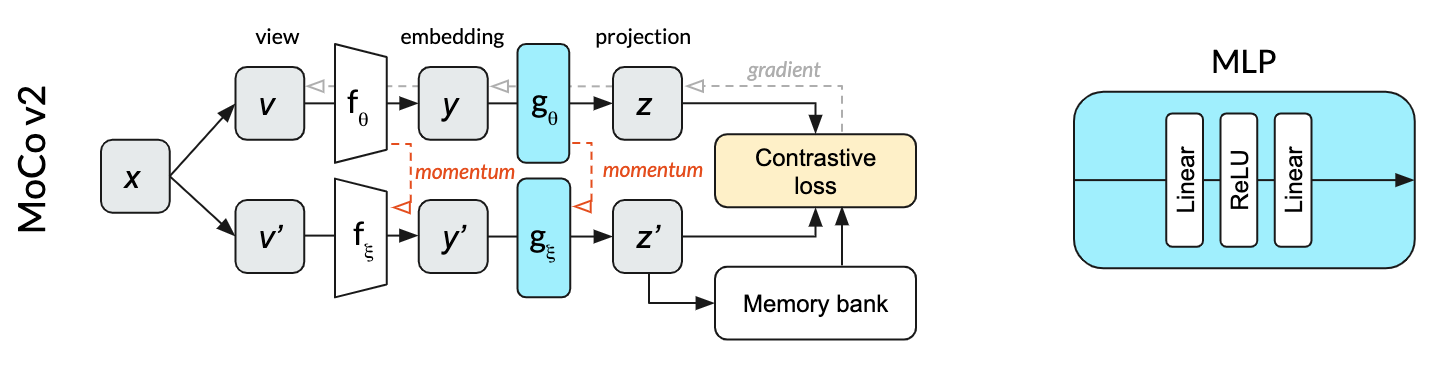

## SimCLR
* \+
    * no special architecture
    * no memory back
* \-
    * need large batch size to get decent amountof negative samples

Only 1 encoder network f + a shallow projection head (2 layers) g:
* f gives representations used for downstream tasks
* g projects them into smaller latent space for contrastive learning

Training procedure
* sample batch $X=\{x_1..x_N\}$
* sample 2 augmentations $\tau, \tau' \in \mathrm{T}$={crop,resize,flip, color distortions,Gaussian blur}
* $Y = \{y_1..y_{2_N}\}$, where $y_{2i-1}=\tau(x_i), y_{2i}=\tau'(x_i)$
* $h_i = f(y_i), ~z_i = g(h_i)$
* $s_{i,j} = \text{cos_sim}(z_i,z_j) ~\text{for}~ i,j \in 1..2N$ <br/>
    - $l_{i,j} = \text{Softmax}(\{s_{i,j}, j \neq i\})$ <br/>
    - $L = \frac{1}{2N} \sum_{k=1}^{N} (l_{2k-1,2k} + l_{2k,2k-1})$
    
* update weights with SGD

Comparison:
* loss: InfoNCE (almost)

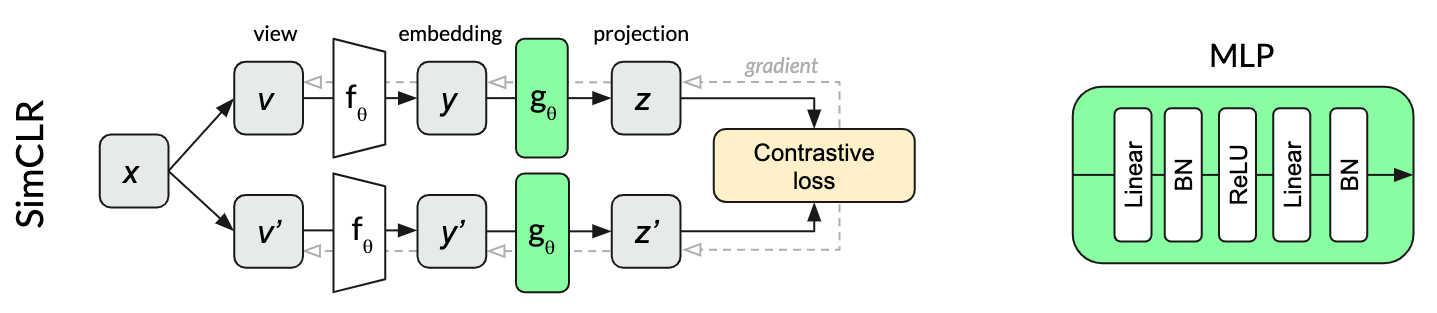

### Contributions

1. CL needs stronger augmentations than supervised (especially color augmentations) <br/>
Table shows that SSL benefits from stronger color distortion
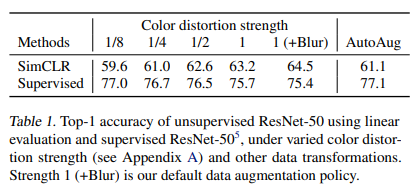

2. CL benefits from deeper projection heads <br/>
Compared 3 heads:
    1. identity
    2. linear layer
    3. linear + ReLU + linear
Performance was $1 \prec 2 (+3\%) \prec 3 (>10\%)$

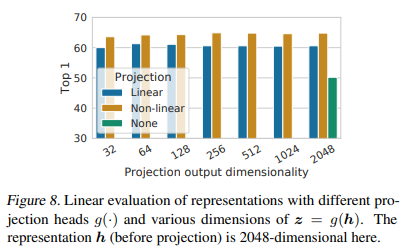

3. CL benefits from larger batch size (BS) and more epochs (EPs) than supervised learning <br/>
    * When #EPs is small (100) large BS is crucial
    * When #EPs is large (1000) gap decreases
    
__Note:__ compare to MoCo (BS=256, EPs=200)

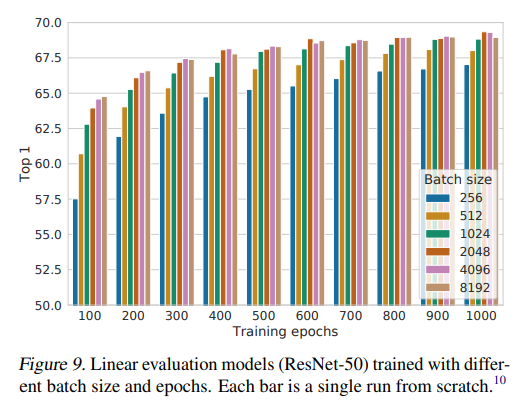

## MoCo v2 (CVPR'20)
MoCo v2 = MoCo + some of SimCLR:
1. larger head (1 layer in MoCo -> 2 layer with non linearity)
2. more colour augmentations (the same used in SimCLR)

## SimCLR v2
Contributions:
1. benefits of deeper projection heads
    * even deeper than in SimCLR is better
    * better to take middle layer of projection head for finetuning
2. use deeper ResNet with fewer channels
3. use memory mechanism from MoCo in addition to large BS with lots of negative examples
4. add self-training<br/>
Overall:
1. pretraing on pretext task -> N1
2. finetune on lbld imgs -> N2
3. use N2 as teacher network to label unlbld imgs
4. teach a student network N3 on imgs lbld in #3 ($L^{distill}$) or on them combined with true lbls ($L$)<br/>
Notions: $P^T$ - prediction of N2, $P^S$ - prediction of N3
![distill](SimCLR_loss_distill.png)
![combined](SimCLR_loss_combined.png)

## Bootstrap Your Own Latent (BYOL) (2020)


Contribution: train without negative samples

How:
* online network N1, momentum network N2 (as in MoCo)
* penalize only positive examples, passed through N1 and N2
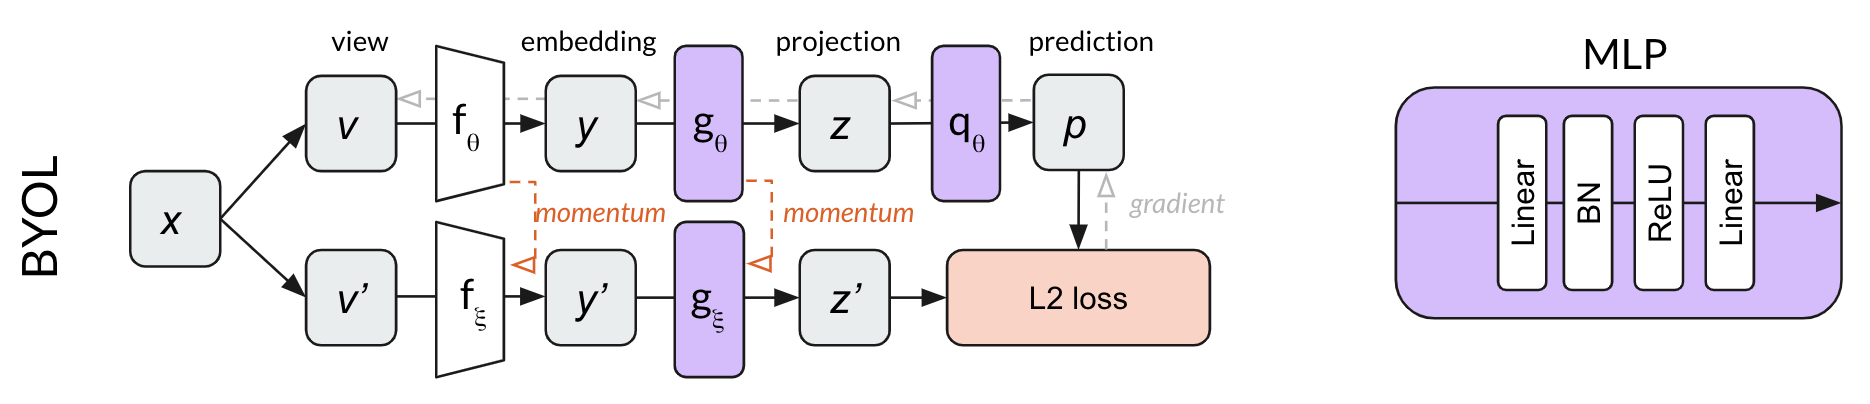

#### Critique
A. Fetterman, J. Albrecht [post](https://generallyintelligent.ai/understanding-self-supervised-contrastive-learning.html):
1. without batchnorm BYOL performs no better than random
2. batchnorm implicitly causes a form of contrastive learning

Batchnorm prevents mode collapse. In fact NN could predict [1,0,0,...] for any input $x$). But batchnorm subtracts mean prediction (i.e. common mode). Thus the common mode serves as implicit negative examples.

Apparently, batchnorm prevents mode collapse
Therefore they suggest:
1. not to use batchnorm when suggesting different CL methods
2. analyze batchnorm usage separately